In [1]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists

import torch
from torch.nn import CrossEntropyLoss
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torchinfo import summary

from util import test_loss_Unet, train_U_NET, plot_loss, plot_acc, inference_time

plt.rcParams['figure.dpi'] = 100

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [3]:
batch_size = 4
image_size = (256, 256)
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.CenterCrop(image_size)])

target_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(0.007843137718737125, 0.003921568393707275),transforms.CenterCrop(image_size), 
    transforms.Normalize(-1, 1)])

train_dataset = torchvision.datasets.OxfordIIITPet(root='./data/OxfordIIITPet', split="trainval", target_types="segmentation",
                                        download=True, transform=transform, target_transform=target_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.OxfordIIITPet(root='./data/OxfordIIITPet', split="test", target_types="segmentation",
                                        download=True, transform=transform, target_transform=target_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

input_shape = (batch_size, 3, image_size[0], image_size[1])

## UNet with ASL

In [4]:
from Models import U_Net_ASL

U_NN_ASL = U_Net_ASL(input_shape, size_out=3, initial_lr=0.01, momentum=0.9, weight_decay=0, expansion_rate=1, device=device)

summary(U_NN_ASL, input_shape)

Layer (type:depth-idx)                        Output Shape              Param #
U_Net_ASL                                     [4, 3, 256, 256]          --
├─ModuleDict: 1-1                             --                        --
│    └─Sequential: 2-1                        [4, 64, 256, 256]         --
│    │    └─CSC_block: 3-1                    [4, 64, 256, 256]         292
│    │    └─CSC_block: 3-2                    [4, 64, 256, 256]         8,576
│    └─MaxPool2d: 2-2                         [4, 64, 128, 128]         --
│    └─Sequential: 2-3                        [4, 128, 128, 128]        --
│    │    └─CSC_block: 3-3                    [4, 128, 128, 128]        16,896
│    │    └─CSC_block: 3-4                    [4, 128, 128, 128]        33,536
│    └─MaxPool2d: 2-4                         [4, 128, 64, 64]          --
│    └─Sequential: 2-5                        [4, 256, 64, 64]          --
│    │    └─CSC_block: 3-5                    [4, 256, 64, 64]          66,560
│   

In [5]:
PATH = "./models/U_Net/U_NN_ASL.pth"

if exists(PATH):
    U_NN_ASL = torch.load(PATH)
    U_NN_ASL.eval()

In [5]:
criterion = CrossEntropyLoss()
epochs = 30

train_U_NET(U_NN_ASL, criterion=criterion, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
        epochs=epochs, batches_to_test=300, patience=5, device=device, print_test=True, verbose=False, p_randomTransform=0.6)

[1,   300] train_loss: 0.902
test_loss: 0.921, test_accuracy: 59.90392186395412
[1,   600] train_loss: 0.843
test_loss: 0.885, test_accuracy: 60.84653740521834
[1,   900] train_loss: 0.804
test_loss: 0.878, test_accuracy: 61.70812748731986
[2,   280] train_loss: 0.781
test_loss: 0.853, test_accuracy: 61.942028213047664
[2,   580] train_loss: 0.764
test_loss: 0.858, test_accuracy: 58.51305641638027
[2,   880] train_loss: 0.738
test_loss: 0.816, test_accuracy: 63.955524618211705
[3,   260] train_loss: 0.729
test_loss: 0.838, test_accuracy: 60.743178551903405
[3,   560] train_loss: 0.725
test_loss: 0.789, test_accuracy: 65.36211256566311
[3,   860] train_loss: 0.685
test_loss: 0.771, test_accuracy: 65.79359651879024
[4,   240] train_loss: 0.685
test_loss: 0.722, test_accuracy: 69.1673563689229
[4,   540] train_loss: 0.678
test_loss: 0.684, test_accuracy: 72.44511310850837
[4,   840] train_loss: 0.654
test_loss: 0.724, test_accuracy: 69.48632286822448
[5,   220] train_loss: 0.648
test_loss

In [6]:
torch.save(U_NN_ASL, "./models/U_Net/U_NN_ASL.pth")

In [5]:
U_NN_ASL = torch.load("./models/U_Net/U_NN_ASL.pth")

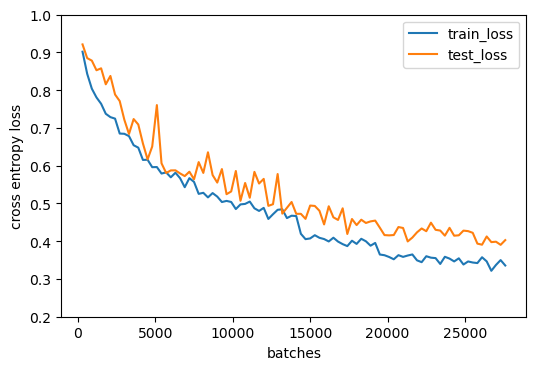

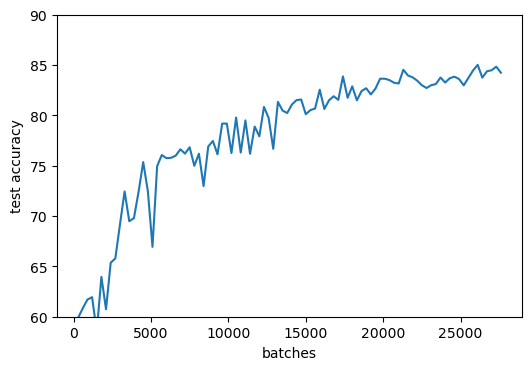

In [6]:
plot_loss(U_NN_ASL, y_lim=(0.2, 1))
plot_acc(U_NN_ASL, y_lim=(60, 90))

In [5]:
print("Training time (s):")
print(f"mean: {round(np.mean(U_NN_ASL.train_time), 3)}")
print(f"std: {round(np.std(U_NN_ASL.train_time), 3)}")

Training time (s):
mean: 232.997
std: 9.255


In [7]:
inference_times = inference_time(U_NN_ASL, input_shape=(1, 3, 32, 32), repetitions=1000, device="cuda")
print("Inference time GPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time GPU (ms):
2.196e+01
1.0e+00


In [8]:
inference_times = inference_time(U_NN_ASL, input_shape=(1, 3, 32, 32), repetitions=1000, device="cpu")
print("Inference time CPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time CPU (ms):
1.522e+01
2.0e+00


In [9]:
inference_times = inference_time(U_NN_ASL, input_shape=(10, 3, 32, 32), repetitions=1000, device="cuda")
print("Inference time GPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time GPU (ms):
3.423e+01
1.9e-01


In [10]:
inference_times = inference_time(U_NN_ASL, input_shape=(10, 3, 32, 32), repetitions=1000, device="cpu")
print("Inference time CPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time CPU (ms):
5.740e+01
5.5e+00


In [8]:
inference_times = inference_time(U_NN_ASL, input_shape=(50, 3, 32, 32), repetitions=1000, device="cuda")
print("Inference time GPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time GPU (ms):
9.618e+01
8.2e-01


In [9]:
inference_times = inference_time(U_NN_ASL, input_shape=(50, 3, 32, 32), repetitions=1000, device="cpu")
print("Inference time CPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time CPU (ms):
3.318e+02
3.6e+01


222


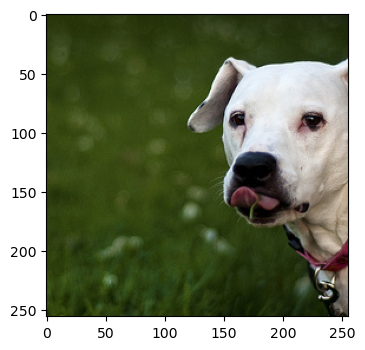

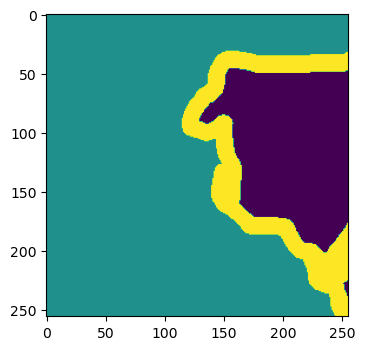

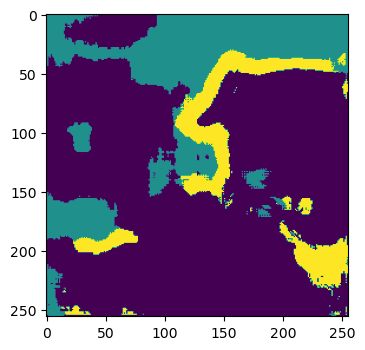

In [7]:
def show_segmentation_results(NN, dataset, index, device):
    img = torch.transpose(dataset[index][0], 2, 0)
    img = torch.transpose(img, 1,0)
    plt.imshow(img)
    plt.show()

    plt.imshow(dataset[index][1][0])
    plt.show()

    seg = dataset[index][0]
    seg = seg[None,:,:,:].to(device)
    outputs = NN(seg)
    outputs = torch.argmax(outputs, 1, keepdim=True)
    plt.imshow(outputs[0][0].detach().to("cpu").numpy())
    plt.show()

ind = int(np.random.rand(1) * 1000)
print(ind)
show_segmentation_results(U_NN_ASL, test_dataset, ind, device)

TypeError: 'MaxPool2d' object is not subscriptable

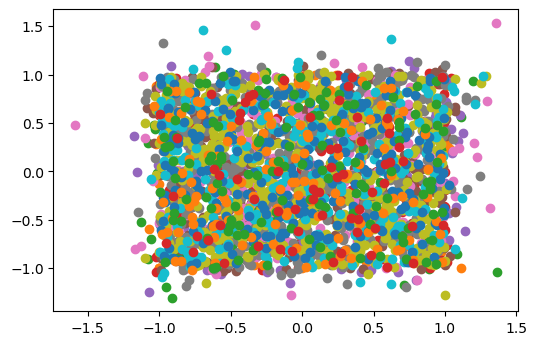

In [26]:

from util import plot_shifts

for layer in U_NN_ASL.NN:

    shifts = U_NN_ASL.NN[layer][0].NN[3].shifts.detach().to("cpu").numpy()
    #print(shifts)
    plt.scatter(shifts[:,0], shifts[:,1])
    shifts = U_NN_ASL.NN[layer][1].NN[3].shifts.detach().to("cpu").numpy()
    #print(shifts)
    plt.scatter(shifts[:,0], shifts[:,1])
    #plt.show()
